# Corrected gauge transformation on the GPU

Set parameters and environment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 1          		
mu = g2mu / g**2

ns = 50      


nevents = 100

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.approx_gauge_trans as lc_gauge

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


We create the simulation routine

In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the objects to store the fields at every time step
    ux_sim = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We simulate the event and store the Glasma fields at every time step
    with tqdm(total=nplus) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # When the time and space lattices match we store the fields
            if t%DTS == 0:
                u1 = s.u1.copy()
                ux_sim[t//DTS] = u1[:, 0, :]
            
                aeta_sim[t//DTS] = s.aeta1.copy()
        
                pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We reshape the field arrays in a suitable way for the GPu gauge transformation
    ux = ux_sim.reshape((nplus*N*N, su.GROUP_ELEMENTS))
    aeta = aeta_sim.reshape((nplus*N*N, su.GROUP_ELEMENTS))
    
    # We create the necessary objects for the gauge transformations
    lc = lc_gauge.LCGaugeTransf(s, nplus, ux, aeta)
    
    # We create an object to store the gauge links
    up_temp = su.GROUP_TYPE(np.zeros((nplus, N*N, su.GROUP_ELEMENTS)))
    up_lc = su.GROUP_TYPE(np.zeros((nplus-1, N*N, su.GROUP_ELEMENTS)))
    
    # We copy the fields to the GPU
    lc.init()
    
    # We start the gauge transformation
    with tqdm(total=nplus) as pbar:
        for xplus in range(nplus):
                
            # We evolve the fields and perform the simulation
            lc.evolve_lc(xplus)
            
            up_temp[xplus] = lc.up_temp_reorder.copy()    
            
            if xplus != 0:
                up_lc[xplus-1] = lc.up_lc_reorder.copy()
                
        
            pbar.update(1)  
    
    # We write the transformed fields in a dictionary
    output["up_lc"] = up_lc
    output["up_temp"] = up_temp
    
    return output

We perform the simulation

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    up_lc = output['up_lc']
    # up_temp = output['up_temp']
    
    # np.save(os.path.join('simulations', 'g=1.25_approx', 'result_%i.npy' %n), up_temp)
    np.save(os.path.join('simulations', 'mid_rapidity_lc', 'result_%i.npy' %n), up_lc)

Event 0


100%|██████████| 32/32 [00:00<00:00, 56.50it/s]


Event 1


100%|██████████| 32/32 [00:00<00:00, 368.03it/s]


Event 2


100%|██████████| 32/32 [00:00<00:00, 375.16it/s]


Event 3


100%|██████████| 32/32 [00:00<00:00, 375.88it/s]


Event 4


100%|██████████| 32/32 [00:00<00:00, 378.73it/s]


Event 5


100%|██████████| 32/32 [00:00<00:00, 382.92it/s]


Event 6


100%|██████████| 32/32 [00:00<00:00, 369.87it/s]


Event 7


100%|██████████| 32/32 [00:00<00:00, 367.64it/s]


Event 8


100%|██████████| 32/32 [00:00<00:00, 367.46it/s]


Event 9


100%|██████████| 32/32 [00:00<00:00, 412.99it/s]


Event 10


100%|██████████| 32/32 [00:00<00:00, 366.89it/s]


Event 11


100%|██████████| 32/32 [00:00<00:00, 273.15it/s]


Event 12


100%|██████████| 32/32 [00:00<00:00, 411.45it/s]


Event 13


100%|██████████| 32/32 [00:00<00:00, 366.37it/s]


Event 14


100%|██████████| 32/32 [00:00<00:00, 369.29it/s]


Event 15


100%|██████████| 32/32 [00:00<00:00, 410.81it/s]


Event 16


100%|██████████| 32/32 [00:00<00:00, 414.27it/s]


Event 17


100%|██████████| 32/32 [00:00<00:00, 367.70it/s]


Event 18


100%|██████████| 32/32 [00:00<00:00, 367.48it/s]


Event 19


100%|██████████| 32/32 [00:00<00:00, 366.72it/s]


Event 20


100%|██████████| 32/32 [00:00<00:00, 366.15it/s]


Event 21


100%|██████████| 32/32 [00:00<00:00, 367.10it/s]


Event 22


100%|██████████| 32/32 [00:00<00:00, 403.17it/s]


Event 23


100%|██████████| 32/32 [00:00<00:00, 299.77it/s]


Event 24


100%|██████████| 32/32 [00:00<00:00, 272.32it/s]


Event 25


100%|██████████| 32/32 [00:00<00:00, 367.54it/s]


Event 26


100%|██████████| 32/32 [00:00<00:00, 408.50it/s]


Event 27


100%|██████████| 32/32 [00:00<00:00, 365.15it/s]


Event 28


100%|██████████| 32/32 [00:00<00:00, 367.56it/s]


Event 29


100%|██████████| 32/32 [00:00<00:00, 281.03it/s]


Event 30


100%|██████████| 32/32 [00:00<00:00, 372.30it/s]


Event 31


100%|██████████| 32/32 [00:00<00:00, 308.57it/s]


Event 32


100%|██████████| 32/32 [00:00<00:00, 415.40it/s]


Event 33


100%|██████████| 32/32 [00:00<00:00, 412.33it/s]


Event 34


100%|██████████| 32/32 [00:00<00:00, 370.39it/s]


Event 35


100%|██████████| 32/32 [00:00<00:00, 400.14it/s]


Event 36


100%|██████████| 32/32 [00:00<00:00, 370.66it/s]


Event 37


100%|██████████| 32/32 [00:00<00:00, 365.86it/s]


Event 38


100%|██████████| 32/32 [00:00<00:00, 371.65it/s]


Event 39


100%|██████████| 32/32 [00:00<00:00, 369.68it/s]


Event 40


100%|██████████| 32/32 [00:00<00:00, 411.99it/s]


Event 41


100%|██████████| 32/32 [00:00<00:00, 367.42it/s]


Event 42


100%|██████████| 32/32 [00:00<00:00, 370.66it/s]


Event 43


100%|██████████| 32/32 [00:00<00:00, 368.68it/s]


Event 44


100%|██████████| 32/32 [00:00<00:00, 368.78it/s]


Event 45


100%|██████████| 32/32 [00:00<00:00, 413.39it/s]


Event 46


100%|██████████| 32/32 [00:00<00:00, 372.67it/s]


Event 47


100%|██████████| 32/32 [00:00<00:00, 368.01it/s]


Event 48


100%|██████████| 32/32 [00:00<00:00, 414.32it/s]


Event 49


100%|██████████| 32/32 [00:00<00:00, 369.28it/s]


Event 50


100%|██████████| 32/32 [00:00<00:00, 264.78it/s]


Event 51


100%|██████████| 32/32 [00:00<00:00, 370.24it/s]


Event 52


100%|██████████| 32/32 [00:00<00:00, 371.06it/s]


Event 53


100%|██████████| 32/32 [00:00<00:00, 372.70it/s]


Event 54


100%|██████████| 32/32 [00:00<00:00, 372.64it/s]


Event 55


100%|██████████| 32/32 [00:00<00:00, 371.32it/s]


Event 56


100%|██████████| 32/32 [00:00<00:00, 372.67it/s]


Event 57


100%|██████████| 32/32 [00:00<00:00, 371.67it/s]


Event 58


100%|██████████| 32/32 [00:00<00:00, 372.27it/s]


Event 59


100%|██████████| 32/32 [00:00<00:00, 371.13it/s]


Event 60


100%|██████████| 32/32 [00:00<00:00, 305.30it/s]


Event 61


100%|██████████| 32/32 [00:00<00:00, 411.91it/s]


Event 62


100%|██████████| 32/32 [00:00<00:00, 369.58it/s]


Event 63


100%|██████████| 32/32 [00:00<00:00, 370.10it/s]


Event 64


100%|██████████| 32/32 [00:00<00:00, 416.00it/s]


Event 65


100%|██████████| 32/32 [00:00<00:00, 359.39it/s]


Event 66


100%|██████████| 32/32 [00:00<00:00, 367.91it/s]


Event 67


100%|██████████| 32/32 [00:00<00:00, 367.77it/s]


Event 68


100%|██████████| 32/32 [00:00<00:00, 367.97it/s]


Event 69


100%|██████████| 32/32 [00:00<00:00, 378.89it/s]


Event 70


100%|██████████| 32/32 [00:00<00:00, 366.85it/s]


Event 71


100%|██████████| 32/32 [00:00<00:00, 365.93it/s]


Event 72


100%|██████████| 32/32 [00:00<00:00, 365.91it/s]


Event 73


100%|██████████| 32/32 [00:00<00:00, 365.18it/s]


Event 74


100%|██████████| 32/32 [00:00<00:00, 409.95it/s]


Event 75


100%|██████████| 32/32 [00:00<00:00, 365.18it/s]


Event 76


100%|██████████| 32/32 [00:00<00:00, 367.47it/s]


Event 77


100%|██████████| 32/32 [00:00<00:00, 366.61it/s]


Event 78


100%|██████████| 32/32 [00:00<00:00, 363.38it/s]


Event 79


100%|██████████| 32/32 [00:00<00:00, 366.70it/s]


Event 80


100%|██████████| 32/32 [00:00<00:00, 365.05it/s]


Event 81


100%|██████████| 32/32 [00:00<00:00, 366.09it/s]


Event 82


100%|██████████| 32/32 [00:00<00:00, 367.10it/s]


Event 83


100%|██████████| 32/32 [00:00<00:00, 287.94it/s]


Event 84


100%|██████████| 32/32 [00:00<00:00, 409.83it/s]


Event 85


100%|██████████| 32/32 [00:00<00:00, 414.32it/s]


Event 86


100%|██████████| 32/32 [00:00<00:00, 372.58it/s]


Event 87


100%|██████████| 32/32 [00:00<00:00, 374.54it/s]


Event 88


100%|██████████| 32/32 [00:00<00:00, 371.61it/s]


Event 89


100%|██████████| 32/32 [00:00<00:00, 367.12it/s]


Event 90


100%|██████████| 32/32 [00:00<00:00, 370.14it/s]


Event 91


100%|██████████| 32/32 [00:00<00:00, 370.41it/s]


Event 92


100%|██████████| 32/32 [00:00<00:00, 416.51it/s]


Event 93


100%|██████████| 32/32 [00:00<00:00, 370.32it/s]


Event 94


100%|██████████| 32/32 [00:00<00:00, 416.78it/s]


Event 95


100%|██████████| 32/32 [00:00<00:00, 370.12it/s]


Event 96


100%|██████████| 32/32 [00:00<00:00, 369.97it/s]


Event 97


100%|██████████| 32/32 [00:00<00:00, 370.86it/s]


Event 98


100%|██████████| 32/32 [00:00<00:00, 368.40it/s]


Event 99


100%|██████████| 32/32 [00:00<00:00, 369.41it/s]


We plot the results

In [5]:
# We extract the color components
up_lc_r = up_lc.reshape(nplus-1, N, N, su.GROUP_ELEMENTS)
up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc_r)

up_temp_r = up_temp.reshape(nplus, N, N, su.GROUP_ELEMENTS)
up_temp_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_temp_r)

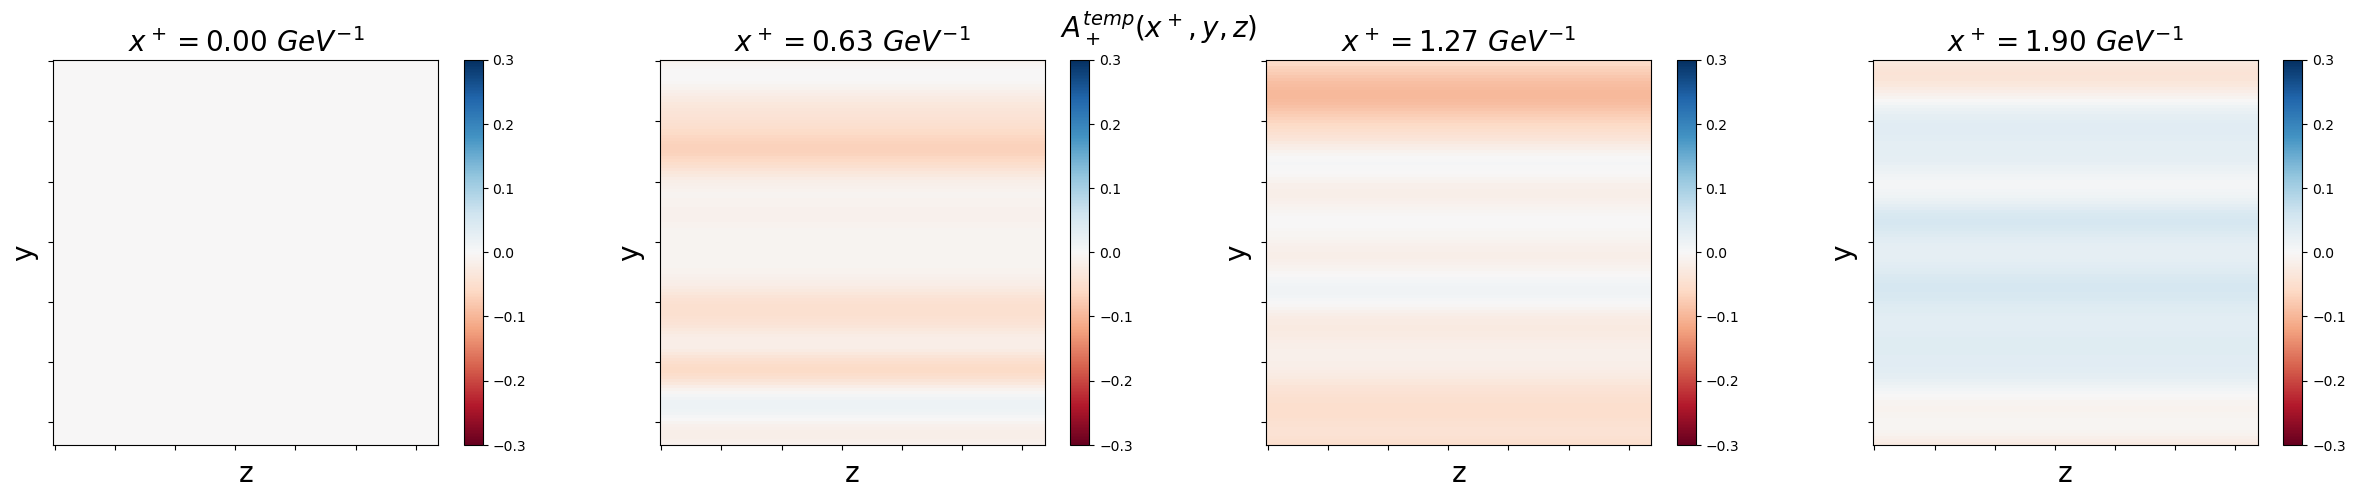

In [10]:
# We plot the temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//8, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//8): 
    xplus = 8*t
    
    plot1 = axs[t].imshow(up_temp_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-0.3, vmax=0.3) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('zoom arround z=0')

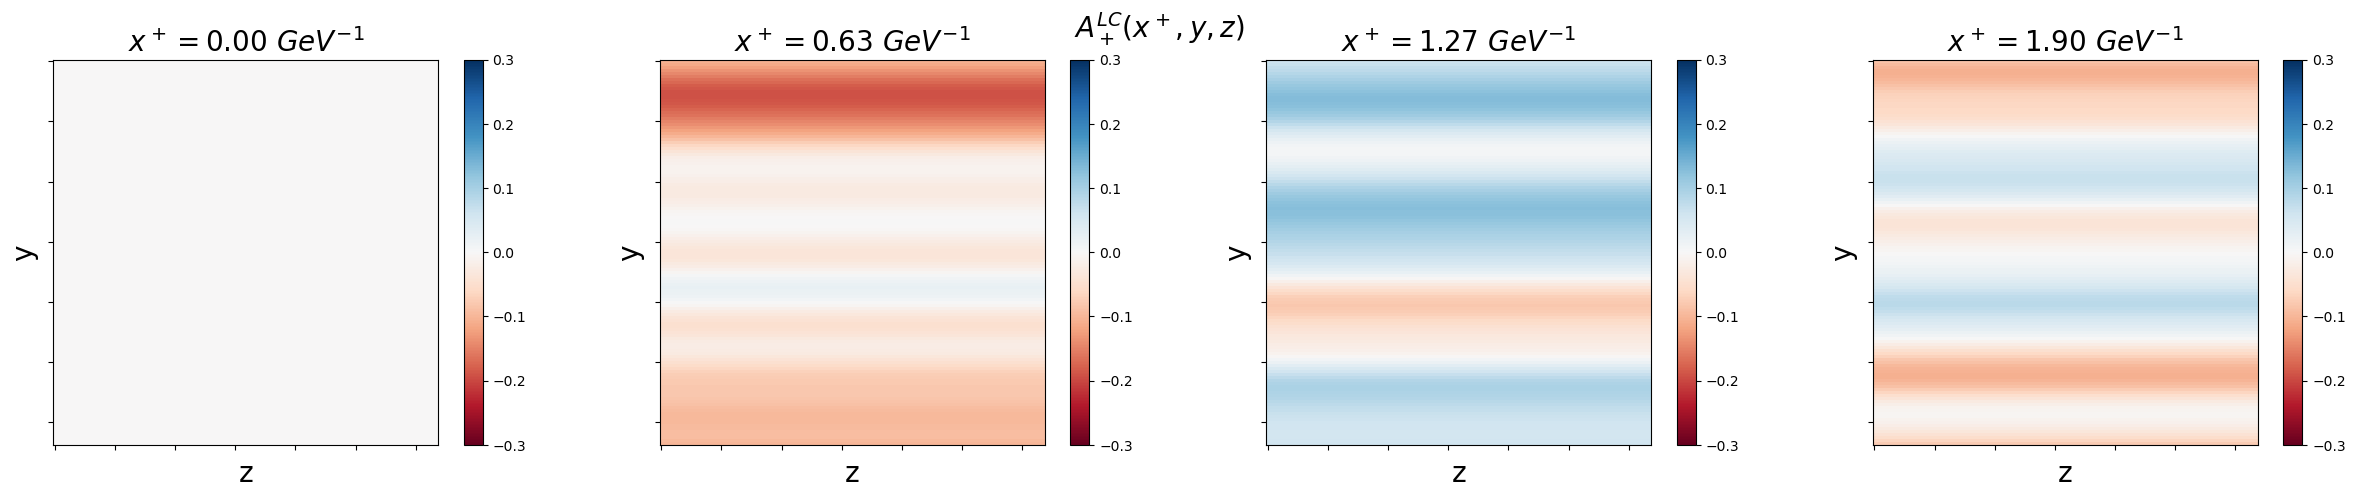

In [12]:
# We plot the LC gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//8, figsize=(30,5))
fig.suptitle(r'$A_+^{LC}(x^+, y, z)$', fontsize=20)

for t in range(nplus//8): 
    xplus = 8*t
    
    plot1 = axs[t].imshow(up_lc_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-0.3, vmax=0.3) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('zoom arround z=0')